In [8]:
# ! pip install -U langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python gpt4all fastembed langchain-groq 

In [9]:
import os
import tempfile
import base64
import fitz
import hashlib
import io
import json
from pprint import pprint
from langchain_community.vectorstores import FAISS
from langchain_core.runnables import RunnablePassthrough
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain.output_parsers import OutputFixingParser
from langchain_text_splitters import CharacterTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader, PyMuPDFLoader

from langchain_community.document_loaders import WebBaseLoader
from pipeline.api_handler import ApiHandler

In [10]:
# Custom function to extract document objects from a given PDF file directory
def extract_documents_from_file(file_dir):
    loader = PyMuPDFLoader(file_dir)

    # Load the document
    documents = loader.load()
    return documents

def get_llm(llm_type, para):
    para = para
    api = ApiHandler(para)
    llm_basic = api.models['basic']['instance']
    llm_advance = api.models['advance']['instance']
    llm_creative = api.models['creative']['instance']
    if llm_type == 'basic':
        return llm_basic
    elif llm_type == 'advance':
        return llm_advance
    elif llm_type == 'creative':
        return llm_creative
    return llm_basic

def get_embedding_models(embedding_model_type, para):
    para = para
    api = ApiHandler(para)
    embedding_model_default = api.embedding_models['default']['instance']
    if embedding_model_type == 'default':
        return embedding_model_default
    else:
        return embedding_model_default
    
def get_db(_documents, embedding_folder, embedding_model):
    """
    Create or load the embeddings for the specified documents.
    """
    # Define the default filenames used by FAISS when saving
    faiss_path = os.path.join(embedding_folder, "index.faiss")
    pkl_path = os.path.join(embedding_folder, "index.pkl")

    # Check if all necessary files exist to load the embeddings
    if os.path.exists(faiss_path) and os.path.exists(pkl_path):
        # Load existing embeddings
        print("Loading existing embeddings...")
        db = FAISS.load_local(
            embedding_folder, embedding_model, allow_dangerous_deserialization=True
        )
    else:
        # Split the documents into chunks
        print("Creating new embeddings...")
        # text_splitter = CharacterTextSplitter(chunk_size=512, chunk_overlap=0)
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=0)
        texts = text_splitter.split_documents(_documents)
        print(f"length of document chunks generated for get_response_source:{len(texts)}")

        # Create the vector store to use as the index
        db = FAISS.from_documents(texts, embedding_model)
        # Save the embeddings to the specified folder
        db.save_local(embedding_folder)
    return db

In [11]:
para = {
    'llm_source': 'openai',  # or 'anthropic'
    'temperature': 0,
    "creative_temperature": 0.5,
    "openai_key_dir": ".env",
    "anthropic_key_dir": ".env",
}
llm = get_llm('basic', para)
embed_model = get_embedding_models('default', para)

In [12]:
dir_path = os.getcwd()
embedding_folder = os.path.join(dir_path, "embedded_content")
inputs_folder = os.path.join(dir_path, "test_inputs")

doc = extract_documents_from_file(inputs_folder + "/test.pdf")
docs = [doc]
docs_list = [item for sublist in docs for item in sublist]
print(f"len of documents :{len(docs_list)}")

# Compute a hashed ID based on the PDF content
doc_content = b"".join([page.page_content.encode('utf-8') for page in docs_list])
file_hash = hashlib.md5(doc_content).hexdigest()
course_id = file_hash
embedding_folder = os.path.join(embedding_folder, course_id)

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=512, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)
print(f"length of document chunks generated :{len(doc_splits)}")

vectorstore = get_db(docs_list, embedding_folder, embed_model)
retriever = vectorstore.as_retriever(search_kwargs={"k":2})

len of documents :7
length of document chunks generated :23
Loading existing embeddings...


# Implement the Router

In [13]:
import time

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a 
    user question to a vectorstore or web search. Use the vectorstore for questions on LLM  agents, 
    prompt engineering, and adversarial attacks. You do not need to be stringent with the keywords 
    in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search' 
    or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and 
    no premable or explaination. Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"],
)
start = time.time()
question_router = prompt | llm | JsonOutputParser()
# TEST
question = "llm agent memory"
print(question_router.invoke({"question": question}))
end = time.time()
print(f"The time required to generate response by Router Chain in seconds:{end - start}")

{'datasource': 'vectorstore'}
The time required to generate response by Router Chain in seconds:0.7335789203643799


# Implement the Generate Chain

In [14]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question} 
    Context: {context} 
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Implement the Retrieval Grader

In [15]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance 
    of a retrieved document to a user question. If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)
start = time.time()
retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))
end = time.time()
print(f"The time required to generate response by the retrieval grader in seconds:{end - start}")

{'score': 'no'}
The time required to generate response by the retrieval grader in seconds:0.7011890411376953


# Implement the hallucination grader

In [16]:
generation = []
prompt = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether 
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate 
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)
start = time.time()
hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader_response = hallucination_grader.invoke({"documents": docs, "generation": generation})
end = time.time()
print(f"The time required to generate response by the generation chain in seconds:{end - start}")
print(hallucination_grader_response)

The time required to generate response by the generation chain in seconds:0.36733102798461914
{'score': 'no'}


# Implement the Answer Grader

In [17]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an 
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)
start = time.time()
answer_grader = prompt | llm | JsonOutputParser()
answer_grader_response = answer_grader.invoke({"question": question,"generation": generation})
end = time.time()
print(f"The time required to generate response by the answer grader in seconds:{end - start}")
print(answer_grader_response)

The time required to generate response by the answer grader in seconds:0.30743885040283203
{'score': 'no'}


# Implement Web Search tool

In [18]:
import os
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
load_dotenv(".env")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
web_search_tool = TavilySearchResults(k=3)

Define the Graph State : represents state of the graph.

Define the following attributes:

1. question

2. generation : LLM Generation

3. web_search : whether to add search

4. documents : list of documents

In [19]:
from typing_extensions import TypedDict
from typing import List

### State

class GraphState(TypedDict):
    question : str
    generation : str
    web_search : str
    documents : List[str]

# Define the Nodes

In [20]:
from langchain.schema import Document
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}
#
def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}
#
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score['score']
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}
#
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])  # Set to an empty list if "documents" key is not present

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}
#

# Define Conditional Edges

In [21]:
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})  
    print(source)
    print(source['datasource'])
    if source['datasource'] == 'web_search':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source['datasource'] == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [22]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [23]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score['score']

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question,"generation": generation})
        grade = score['score']
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

# Add nodes

In [24]:
from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generatae

# Set the Entry Point and End Point

In [25]:
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)

# Compile the workflow

In [26]:
app = workflow.compile()

# Test the Workflow

In [27]:
from pprint import pprint
# inputs = {"question": "What is prompt engineering?"}
inputs = {"question": "What is the advantage of multiplexing"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
What is the advantage of multiplexing
{'datasource': 'web_search'}
web_search
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('The advantages of multiplexing include increased efficiency by allowing '
 'multiple signals to be transmitted simultaneously over a single channel, '
 'which enhances data transmission rates. It also reduces costs by minimizing '
 'the number of communication channels required. Additionally, multiplexing '
 'enables more effective utilization of the available bandwidth.')


# Test The Workflow for a different question

In [28]:
# !brew install graphviz
# !conda install -c conda-forge pygraphviz

In [29]:
# Test
from pprint import pprint
inputs = {"question": "Who are the Bears expected to draft first in the NFL draft?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
Who are the Bears expected to draft first in the NFL draft?
{'datasource': 'web_search'}
web_search
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('The Bears are expected to draft USC quarterback Caleb Williams first overall '
 'in the 2024 NFL Draft. He is regarded as the top prospect in a strong '
 'quarterback class. This selection comes after the Bears moved on from their '
 'previous quarterback, Justin Fields.')


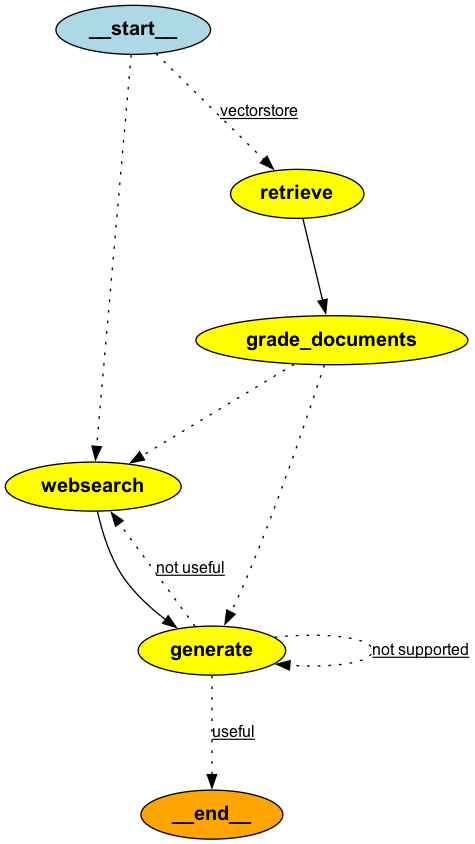

In [30]:
from IPython.display import Image

Image(app.get_graph().draw_png())